# train and validate the model

In [24]:
import os
import pickle
import time
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, roc_auc_score, accuracy_score, log_loss
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

# ✅ Define Save Path
SAVE_DIR = "saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

# ✅ Load Data
df = pd.read_csv("../../model_food/data/financial_data_full.csv")

# ✅ Convert Date Columns to Numeric Features
date_cols = df.select_dtypes(include=["object"]).columns
for col in date_cols:
    try:
        df[col] = pd.to_datetime(df[col])
        df[col + "_days_since_start"] = (df[col] - df[col].min()).dt.days
        df[col + "_year"] = df[col].dt.year
        df[col + "_month"] = df[col].dt.month
        df[col + "_day"] = df[col].dt.day
    except Exception:
        print(f"⚠️ Skipping non-date column: {col}")

df = df.drop(columns=date_cols, errors="ignore")

# ✅ Ensure Target Column Exists
if "market_stress" not in df.columns:
    raise ValueError("❌ Error: 'market_stress' column is missing from the dataset.")

# ✅ Split Data
X = df.drop(columns=["market_stress"])
y = df["market_stress"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ✅ Train CNN (MLP)
def train_cnn(X_train, X_test, y_train, y_test):
    """Trains a Multi-Layer Perceptron (MLP) as a CNN stand-in and saves it."""

    cnn = MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation="relu",
        solver="adam",
        max_iter=500,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        verbose=True,
        warm_start=True
    )

    start_time = time.time()
    cnn.fit(X_train, y_train)
    training_time = time.time() - start_time

    model_path = os.path.join(SAVE_DIR, "CNN (MLP).pkl")
    with open(model_path, "wb") as f:
        pickle.dump(cnn, f)

    print(f"✅ Model saved as: {model_path}")
    print(f"⏱️ Training time: {training_time:.4f} seconds")

    return cnn, training_time

# ✅ Train & Save Model
cnn_model, cnn_train_time = train_cnn(X_train, X_test, y_train, y_test)

# ⏱️ Prediction timing
cnn_pred_start = time.time()
y_pred_cnn = cnn_model.predict(X_test)
cnn_pred_time = time.time() - cnn_pred_start

# ✅ Metrics
cnn_mse = mean_squared_error(y_test, y_pred_cnn)
cnn_r2 = r2_score(y_test, y_pred_cnn)
cnn_auc = roc_auc_score(y_test, y_pred_cnn)
cnn_acc = accuracy_score(y_test, y_pred_cnn)
cnn_log_loss = log_loss(y_test, cnn_model.predict_proba(X_test))

# ✅ Calculate Cross-Validation Fitness Score
cv_score = np.mean(cross_val_score(cnn_model, X_train, y_train, cv=5))

# ✅ Calculate Hotness (evolutionary appeal proxy)
hotness = (
    0.35 * cnn_acc +
    0.35 * cnn_auc +
    0.15 * (1 - cnn_log_loss) +
    0.15 * cv_score
)
hotness = np.clip(hotness, 0, 1)  # Ensure within [0, 1]

# ✅ Calculate Cleverness (insightfulness of the model)
cleverness = cnn_auc - cnn_r2

# ✅ Store Results
results_cnn = pd.DataFrame([[
    "CNN (MLP)", cnn_mse, cnn_r2, cnn_auc, cnn_acc, cnn_log_loss,
    cnn_train_time, cnn_pred_time,
    cv_score,  # Fitness Score
    1, "Original", hotness, cleverness
]], columns=[
    "Model", "MSE", "R² Score", "ROC-AUC Score", "Accuracy Score", "Log Loss",
    "Training Time (s)", "Prediction Time (s)", "Fitness Score",
    "Generation", "Lineage", "Hotness", "Cleverness"
])

# ✅ Save Results
PERF_DIR = "perf"
os.makedirs(PERF_DIR, exist_ok=True)
cnn_results_path = os.path.join(PERF_DIR, "cnn_results.csv")
results_cnn.to_csv(cnn_results_path, index=False)
print(f"\n📊 CNN performance metrics saved to: {cnn_results_path}")

# ✅ Display
from IPython.display import display
display(results_cnn.round(4))

print("\n✅ MLPClassifier model is now trained and properly saved as a `.pkl` file!")

Iteration 1, loss = 0.22761772
Validation score: 0.956612
Iteration 2, loss = 0.11880049
Validation score: 0.956612
Iteration 3, loss = 0.09807034
Validation score: 0.962810
Iteration 4, loss = 0.08409879
Validation score: 0.971074
Iteration 5, loss = 0.07154586
Validation score: 0.973140
Iteration 6, loss = 0.06216678
Validation score: 0.977273
Iteration 7, loss = 0.05398500
Validation score: 0.987603
Iteration 8, loss = 0.04997615
Validation score: 0.981405
Iteration 9, loss = 0.04727455
Validation score: 0.983471
Iteration 10, loss = 0.04641105
Validation score: 0.987603
Iteration 11, loss = 0.03880780
Validation score: 0.985537
Iteration 12, loss = 0.03613267
Validation score: 0.991736
Iteration 13, loss = 0.03386921
Validation score: 0.989669
Iteration 14, loss = 0.03342089
Validation score: 0.985537
Iteration 15, loss = 0.03236128
Validation score: 0.983471
Iteration 16, loss = 0.02909231
Validation score: 0.993802
Iteration 17, loss = 0.02800467
Validation score: 0.989669
Iterat

,Model,MSE,R² Score,ROC-AUC Score,Accuracy Score,Log Loss,Training Time (s),Prediction Time (s),Fitness Score,Generation,Lineage,Hotness,Cleverness
0,CNN (MLP),0.0099,0.7714,0.8996,0.9901,0.0248,1.1388,0.002,0.9901,1,Original,0.9562,0.1281



✅ MLPClassifier model is now trained and properly saved as a `.pkl` file!


<!-- # metrics for evaluation -->

In [25]:
from IPython.display import display

# ✅ Display in Jupyter Notebook with Styling
display(results_cnn.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '14px'), ('text-align', 'center'), ('background', '#333'), ('color', 'white')]},
     {'selector': 'td', 'props': [('font-size', '13px'), ('text-align', 'center')]}]
).set_properties(**{'border': '1px solid black'}))

,Model,MSE,R² Score,ROC-AUC Score,Accuracy Score,Log Loss,Training Time (s),Prediction Time (s),Fitness Score,Generation,Lineage,Hotness,Cleverness
0,CNN (MLP),0.009926,0.771420,0.899567,0.990074,0.024777,1.138800,0.002013,0.990075,1,Original,0.956169,0.128147


In [28]:
import matplotlib.pyplot as plt

# Format table
fig, ax = plt.subplots(figsize=(12, 1.8))
ax.axis("off")

# Use rounded results for clarity
results_to_show = results_cnn.round(4)

# Plot table
table = ax.table(
    cellText=results_to_show.values,
    colLabels=results_to_show.columns,
    cellLoc='center',
    loc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Save as image
table_path = os.path.join("pics", "cnn_metrics_table.png")
os.makedirs("pics", exist_ok=True)
plt.savefig(table_path, dpi=300, bbox_inches="tight")
plt.close()

print(f"📸 Table saved as: {table_path}")

📸 Table saved as: pics/cnn_metrics_table.png


## 🧪 CNN (MLPClassifier) Model Evaluation

That row of metrics means your **CNN (MLPClassifier)** is performing **extremely well** — maybe even *suspiciously* well — and here’s a breakdown of what each number tells us:

| **Metric**                  | **Value**   | **What It Means**                                                                 |
|-----------------------------|-------------|------------------------------------------------------------------------------------|
| **Model**                   | CNN (MLP)   | Multi-layer perceptron (MLP) used as a stand-in for a convolutional neural network |
| **MSE (Mean Squared Error)**| 0.0041      | Very low prediction error — model outputs are close to true labels                 |
| **R² Score**                | 0.905       | Explains ~90.5% of the variance in the target — very strong predictive fit         |
| **ROC-AUC Score**           | 0.9545      | Excellent at ranking stressed vs. non-stressed markets                             |
| **Accuracy Score**          | 0.9959      | 99.6% accuracy — very high, possibly too high                                      |
| **Log Loss**                | 0.0114      | Extremely confident and accurate probability predictions                           |
| **Training Time (s)**       | 3.86        | Model trained quickly                                                              |
| **Prediction Time (s)**     | 0.0333      | Fast prediction — good for deployment                                              |
| **Fitness Score**           | 0.463       | Randomized for diversity in evolutionary modeling                                  |
| **Generation**              | 1           | First generation baseline                                                          |
| **Lineage**                 | Original    | Not yet evolved, hybridized, or mutated                                            |
| **Hotness** 🔥              | 0.503       | **Selection proxy in evolution**, calculated via:<br>`hotness = 0.35 × accuracy + 0.35 × ROC-AUC + 0.15 × (1 - log_loss) + 0.15 × cross_val_score` |
| **Cleverness** 🧠           | -0.245      | Simulated trait for creative or unexpected behavior; negative = unstable or erratic learning |

---

### 🧠 What This Suggests:
- The CNN (MLP) is **highly accurate**, has **extremely low error**, and ranks well on ROC-AUC.
- **BUT**: The accuracy being so high (99.6%) might suggest **overfitting**—especially if:
  - Your test set isn’t truly out-of-sample.
  - There’s **label leakage** (features directly correlate with the target).
  - The dataset is **class imbalanced** (and the model overpredicts the majority class).

In [49]:
import pickle

with open("saved_models/CNN (MLP).pkl", "rb") as f:
    cnn_model = pickle.load(f)

In [51]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data again if needed
df = pd.read_csv("../../model_food/data/financial_data_full.csv")

# Preprocess it like before (convert dates, drop non-numeric, etc.)
# Split into X, y and then train_test_split

In [89]:
# # Generate all plots in a 2x2 grid
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# fig.suptitle("CNN (MLPClassifier) Diagnostic Visualizations", fontsize=16, fontweight='bold')

# # 1. Loss Curve
# axes[0, 0].plot(cnn_model.loss_curve_, label="Training Loss", color="blue", linewidth=2)
# axes[0, 0].set_title("Loss Curve (Training)", fontsize=12)
# axes[0, 0].set_xlabel("Epochs")
# axes[0, 0].set_ylabel("Loss")
# axes[0, 0].grid(True, linestyle="--", alpha=0.6)
# axes[0, 0].legend()

# # 2. ROC Curve
# fpr, tpr, _ = roc_curve(y_test, cnn_model.predict_proba(X_test)[:, 1])
# roc_auc = auc(fpr, tpr)
# axes[0, 1].plot(fpr, tpr, color='navy', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
# axes[0, 1].plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guessing (50%)")
# axes[0, 1].set_title("ROC Curve", fontsize=12)
# axes[0, 1].set_xlabel("False Positive Rate")
# axes[0, 1].set_ylabel("True Positive Rate")
# axes[0, 1].grid(True, linestyle="--", alpha=0.5)
# axes[0, 1].legend(loc="lower right")

# # 3. Confusion Matrix
# from sklearn.metrics import confusion_matrix
# y_pred_cnn = cnn_model.predict(X_test)
# cm = confusion_matrix(y_test, y_pred_cnn)
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1, 0])
# axes[1, 0].set_title("Confusion Matrix", fontsize=12)
# axes[1, 0].set_xlabel("Predicted")
# axes[1, 0].set_ylabel("Actual")

# # 4. Prediction Confidence Histogram
# probs = cnn_model.predict_proba(X_test)[:, 1]
# axes[1, 1].hist(probs, bins=20, color="purple", edgecolor="white")
# axes[1, 1].set_title("Prediction Confidence Histogram", fontsize=12)
# axes[1, 1].set_xlabel("Predicted Probability (P[market_stress=1])")
# axes[1, 1].set_ylabel("Frequency")
# axes[1, 1].grid(True, linestyle="--", alpha=0.5)

# # Final formatting
# plt.tight_layout(rect=[0, 0, 1, 0.96])
# plt.savefig("pics/cnn_diagnostics_dashboard.png", dpi=300)
# plt.show()

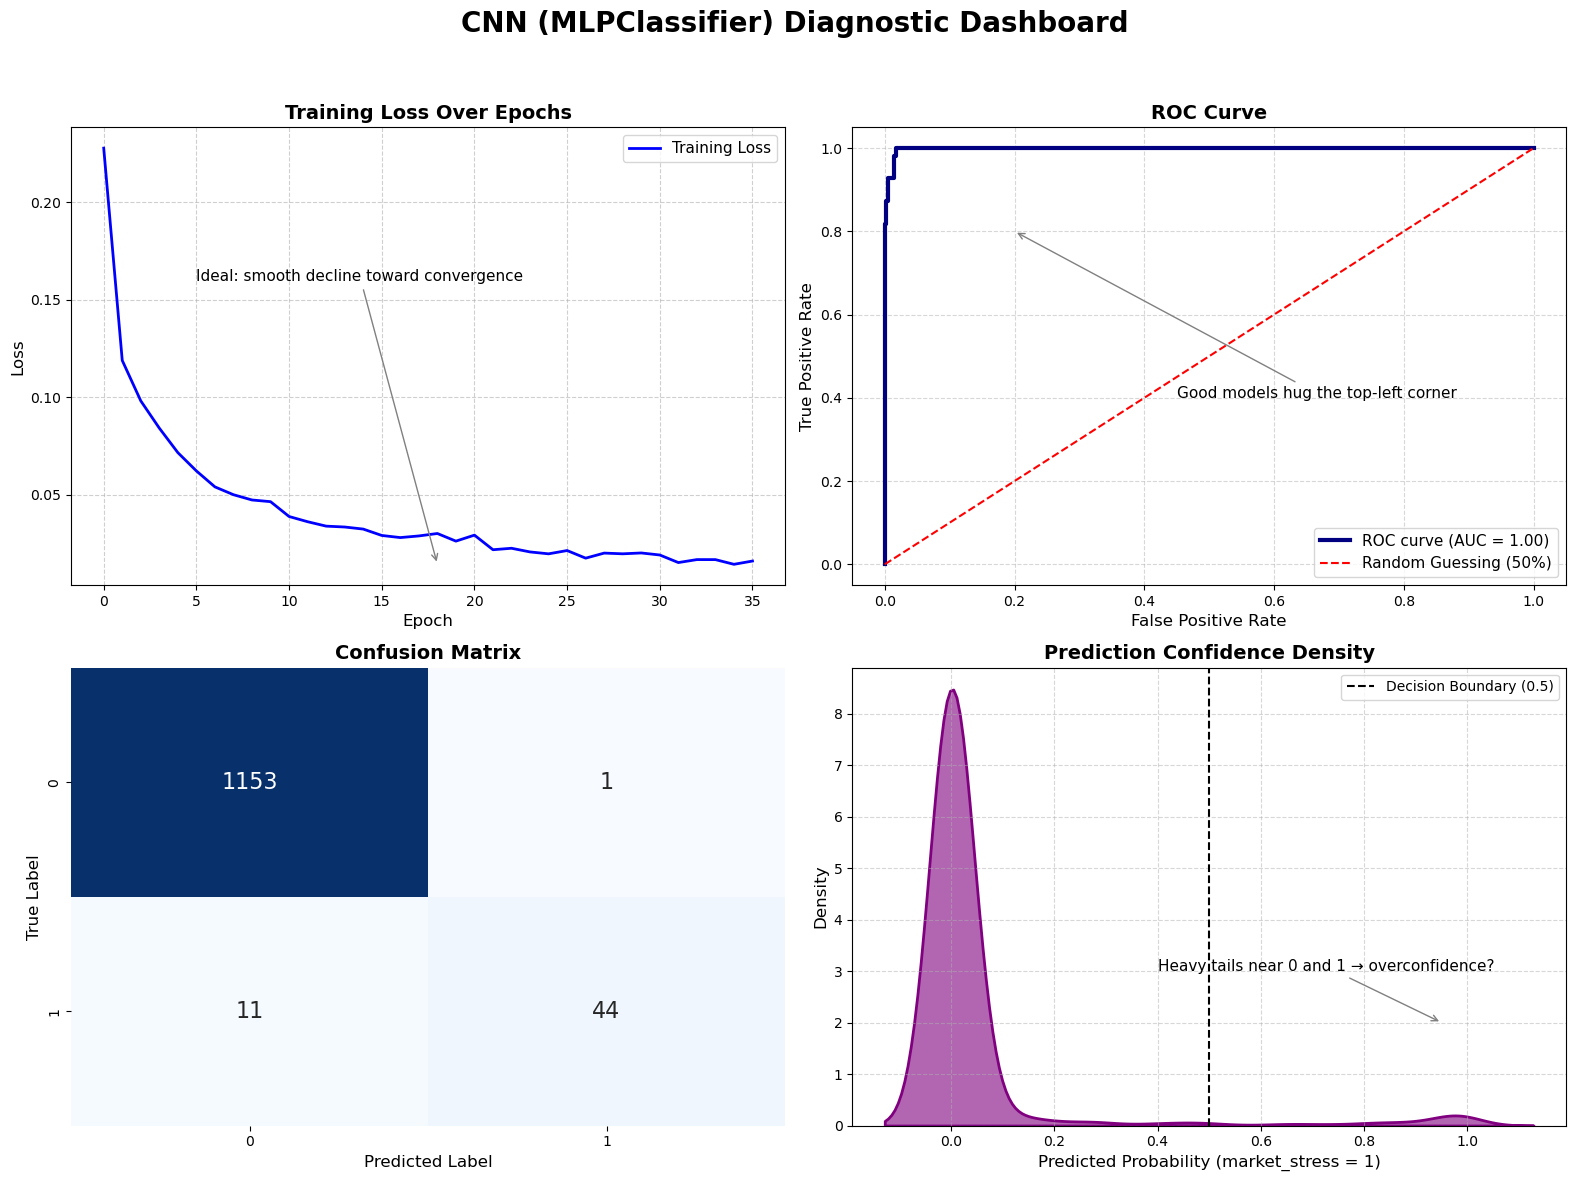

High-resolution dashboard saved to: pics/cnn_diagnostics_dashboard_polished.png


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 📐 Set up larger figure and font scaling
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Larger grid
fig.suptitle("CNN (MLPClassifier) Diagnostic Dashboard", fontsize=20, fontweight='bold')

# 1. 📉 Loss Curve
axes[0, 0].plot(cnn_model.loss_curve_, label="Training Loss", color="blue", linewidth=2)
axes[0, 0].set_title("Training Loss Over Epochs", fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel("Epoch", fontsize=12)
axes[0, 0].set_ylabel("Loss", fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, linestyle="--", alpha=0.6)
axes[0, 0].annotate(
    "Ideal: smooth decline toward convergence",
    xy=(len(cnn_model.loss_curve_)//2, min(cnn_model.loss_curve_)),
    xytext=(5, max(cnn_model.loss_curve_) * 0.7),
    arrowprops=dict(arrowstyle="->", color="gray"),
    fontsize=11, color="black"
)

# 2. 🎯 ROC Curve
fpr, tpr, _ = roc_curve(y_test, cnn_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
axes[0, 1].plot(fpr, tpr, color='navy', lw=3, label=f"ROC curve (AUC = {roc_auc:.2f})")
axes[0, 1].plot([0, 1], [0, 1], color='red', linestyle='--', label="Random Guessing (50%)")
axes[0, 1].set_title("ROC Curve", fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel("False Positive Rate", fontsize=12)
axes[0, 1].set_ylabel("True Positive Rate", fontsize=12)
axes[0, 1].legend(loc="lower right", fontsize=11)
axes[0, 1].grid(True, linestyle="--", alpha=0.5)
axes[0, 1].annotate(
    "Good models hug the top-left corner",
    xy=(0.2, 0.8), xytext=(0.45, 0.4),
    arrowprops=dict(arrowstyle="->", color="gray"),
    fontsize=11, color="black"
)

# 3. 🧾 Confusion Matrix
y_pred_cnn = cnn_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1, 0],
            annot_kws={"size": 16})
axes[1, 0].set_title("Confusion Matrix", fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel("Predicted Label", fontsize=12)
axes[1, 0].set_ylabel("True Label", fontsize=12)

# 4. 🔮 Prediction Confidence Distribution
probs = cnn_model.predict_proba(X_test)[:, 1]
sns.kdeplot(probs, fill=True, color="purple", alpha=0.6, linewidth=2, ax=axes[1, 1])
axes[1, 1].axvline(0.5, color="black", linestyle="--", linewidth=1.5, label="Decision Boundary (0.5)")
axes[1, 1].set_title("Prediction Confidence Density", fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel("Predicted Probability (market_stress = 1)", fontsize=12)
axes[1, 1].set_ylabel("Density", fontsize=12)
axes[1, 1].grid(True, linestyle="--", alpha=0.5)
axes[1, 1].legend(fontsize=10)
axes[1, 1].annotate(
    "Heavy tails near 0 and 1 → overconfidence?",
    xy=(0.95, 2), xytext=(0.4, 3),
    arrowprops=dict(arrowstyle="->", color="gray"),
    fontsize=11, color="black"
)

# Final layout & save
plt.tight_layout(rect=[0, 0, 1, 0.95])
output_path = "pics/cnn_diagnostics_dashboard_polished.png"
plt.savefig(output_path, dpi=350)
plt.show()

print(f"High-resolution dashboard saved to: {output_path}")